In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch

import seaborn as sns
import scanpy as sc
import pandas as pd
import decoupler as dc
import sys
import ast
import functools
import neptune

In [15]:
working_dir = '/home/acollin/scPermut/'
fig_dir = '/home/acollin/scPermut/analysis_notebooks/figures/'

In [16]:
import os
os.chdir(working_dir)

In [17]:
sys.path.append(working_dir)

In [18]:
from scmusketeers.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')


In [19]:
from scmusketeers.workflow.dataset import load_dataset
from scmusketeers.tools.utils import ann_subset, check_raw,save_json, load_json, rgb2hex,hex2rgb,load_expe

In [20]:
def load_expe(neptune_id, working_dir):
    save_dir = result_dir(neptune_id, working_dir)
    X = load_latent_space(neptune_id, working_dir)
    pred = load_pred(neptune_id, working_dir)
    adata = sc.AnnData(X = X, obs = pred)
    # proba_pred = load_proba_pred(neptune_id, working_dir)
    umap = load_umap(neptune_id, working_dir)
    # adata.obsm['proba_pred'] = proba_pred
    adata.obsm['X_umap'] = umap
    return adata


In [13]:
dir = working_dir + 'analysis_notebooks/figures/task_1/celltype_size_heatmap_csv/'
os.listdir(dir)

['xxsmall.csv', 'small.csv', 'medium.csv', 'large.csv', '.ipynb_checkpoints']

In [129]:
aestetic_model_name = {'scPermut_default' : '1.scPermut',
                        'scanvi' : '2.scANVI',
                       'uce' : '3.UCE', 
                       'harmony_svm' : '4.Harmony',
                       'pca_svm' : '5.PCA',
                        'celltypist' : '6.Celltypist',
                       'scmap_cells' : '7.scmap - cells',
                       'scmap_cluster' : '8.scmap - cluster'}
colors = {
          'scPermut_default' : "#B15240",
          'scanvi':"#C78C3B" ,
          'uce':"#D3A53C" ,
          'harmony_svm': "#5B9DC7",
          'pca_svm':"#264D74",
          # 'pca_knn':"#264D80",
          'celltypist': "#75BAD3",
          'scmap_cells':"#607F6A" ,
          'scmap_cluster':"#707C45"}

aestetic_data_name = {'tosti_2021': 'Tosti',
                      # 'tran_2021': 'Tran 2021', 
                      'yoshida_2021': 'Yoshida',
                      'htap': 'Mbouamboua', 
                      'ajrccm_by_batch': 'Deprez',
                      'dominguez_2022_lymph': 'Dominguez - lymph',
                      'dominguez_2022_spleen': 'Dominguez - spleen',
                      'tabula_2022_spleen': 'Tabula - spleen',
                      'koenig_2022': 'Koenig', 
                      'litvinukova_2020': 'Litvinukova', 
                      'lake_2021': 'Lake',
                      'hlca_par_dataset_harmonized': 'HLCA - Parenchyma',
                      'hlca_trac_dataset_harmonized': 'HLCA - Airway'}

In [61]:
s_dict = {}
for p in [i for i in os.listdir(dir) if i.endswith('.csv')]:
    df = pd.read_csv(dir + p, index_col = 0).fillna(0)
    df['Dataset'] = df.index
    s_dict[p.rstrip('.csv')] = df

In [63]:
df

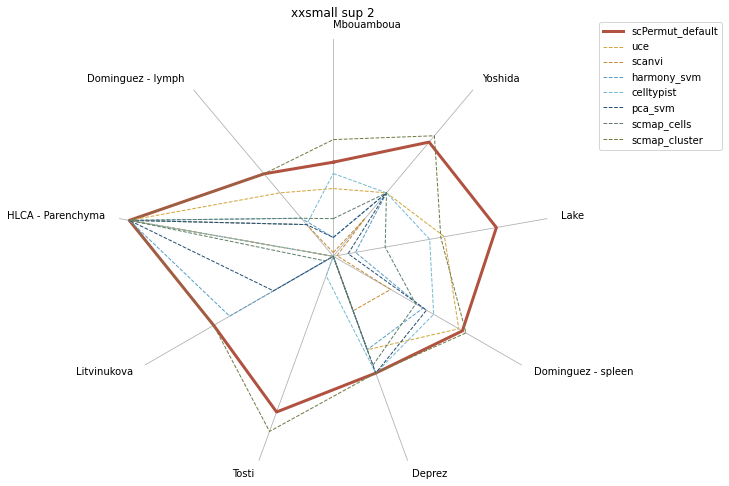

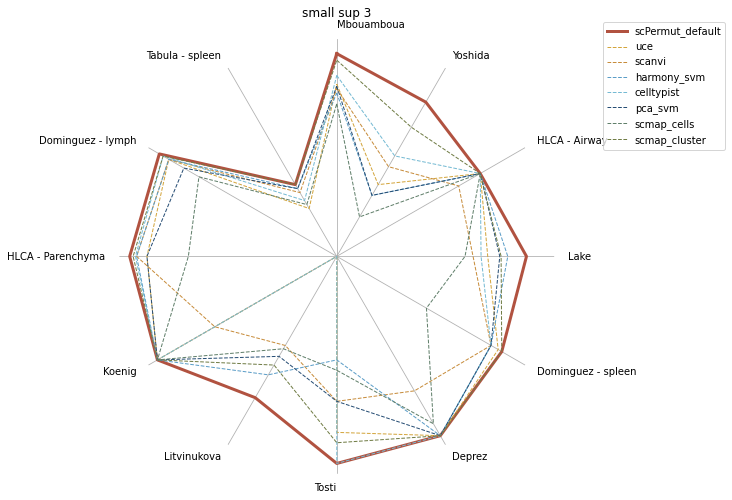

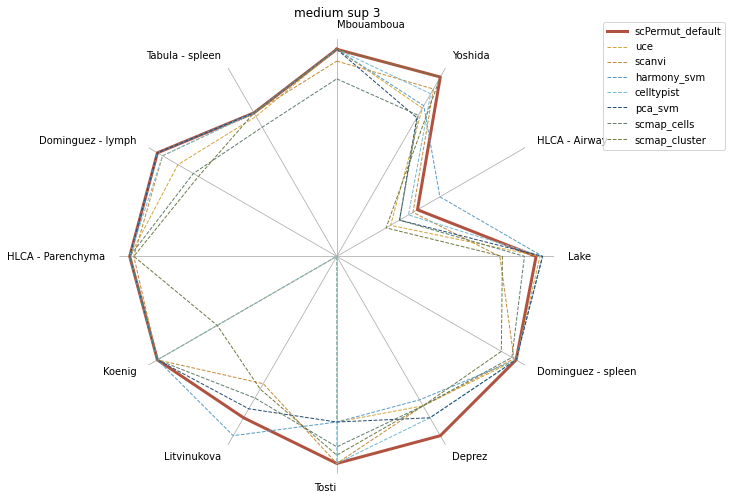

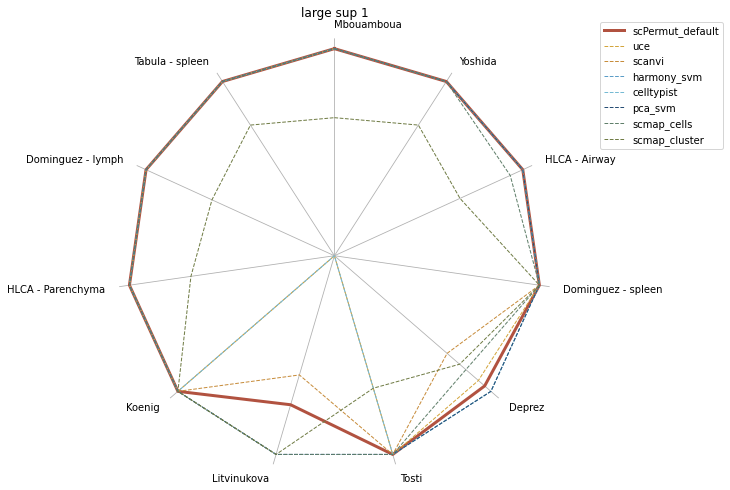

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

for size in s_dict.keys():
    # Création du DataFrame
    df = s_dict[size].copy()
    if size == "xxsmall":
        n_lim = 2
        
    if size == "small":
        n_lim = 3
    if size == "medium":
        n_lim = 3
    if size == "large":
        n_lim = 1
        
    df = df.loc[df['Total'] >=  n_lim]
    title = size + ' sup ' + str(n_lim)
    # df = df.loc[~df['Dataset'].isin(['koenig_2022', 'hlca_par_dataset_harmonized', 'tosti_2021','tabula_2022_spleen' ,'hlca_trac_dataset_harmonized']),]
    
    df['Dataset'] = df['Dataset'].replace(aestetic_data_name)
    
    # Normalisation des valeurs (colonnes sauf "Total")
    df_normalized = df.copy()
    for col in df.columns[:-2]:  # Exclure "Dataset" et "Total"
        df_normalized[col] = df[col] / df["Total"]
    
    # Préparation des données pour le radar chart
    categories = df["Dataset"]
    models = df.columns[:-2]  # Exclure "Dataset" et "Total"
    
    # Création du radar chart
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Fermeture du graphique
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Ajout des modèles au radar chart
    for model in models:
        values = df_normalized[model].tolist()
        values += values[:1]  # Boucler sur le premier point pour fermer le graphique
        if model == 'scPermut_default':
            ax.plot(angles, values, label=model,color = colors[model], linewidth = 3, linestyle = 'solid')
            # ax.fill(angles, values, alpha=0.1, color = colors[model])
        else :
            ax.plot(angles, values, label=model,color = colors[model],linewidth = 1,linestyle = '--')
    
    # Ajustement du graphique
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels('')
    
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        x, y = np.cos(angle), np.sin(angle)
        if angle < np.pi:  # Angles dans la moitié supérieure
            label.set_horizontalalignment('left')
        else:  # Angles dans la moitié inférieure
            label.set_horizontalalignment('right')
        label.set_rotation(np.degrees(angle) + 90)
    
    # ax.set_rscale("linear")
    ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')
    plt.title(title, va='top')
    ax.yaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines["polar"].set_visible(False)
    
    
    plt.savefig(fig_dir + f'/task_1/celltype_size_radar/{size}.png')


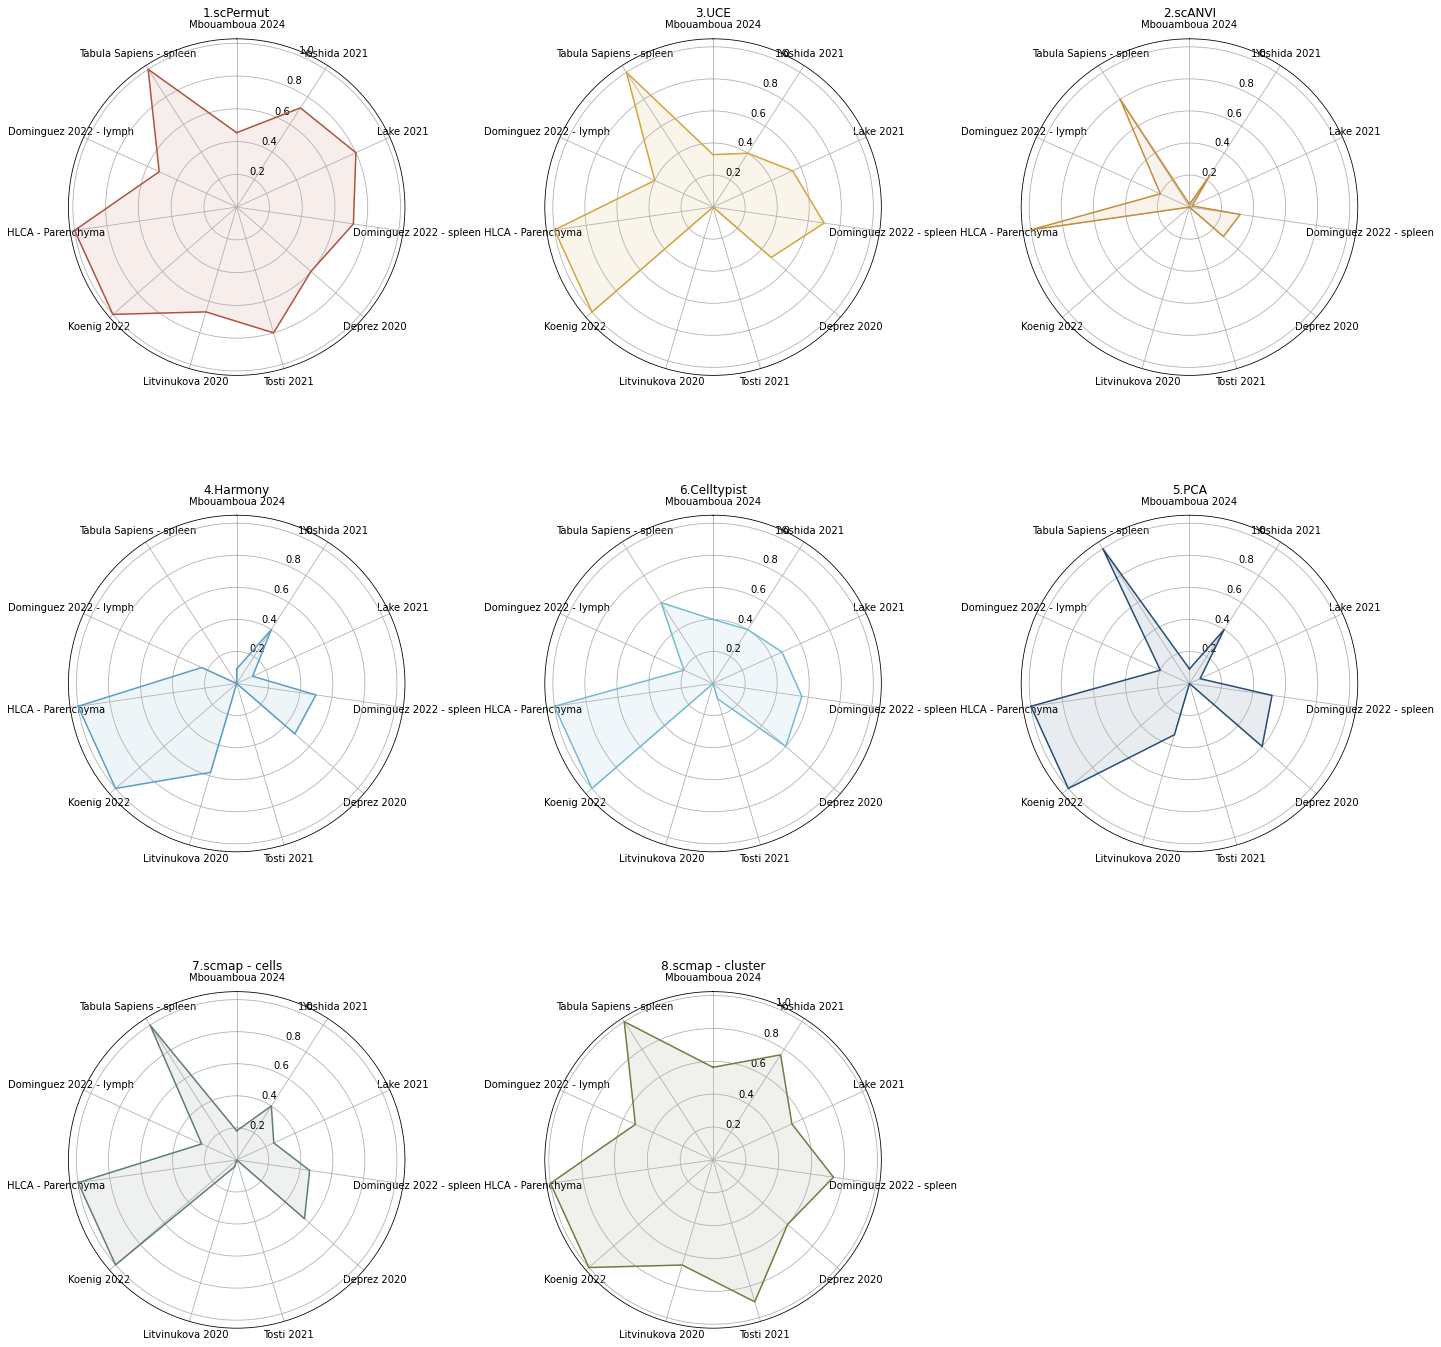

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Données
data = {
    "Dataset": [
        "htap", "yoshida_2021", "lake_2021",
        "dominguez_2022_spleen", "ajrccm_by_batch", "tosti_2021",
        "litvinukova_2020", "koenig_2022", "hlca_par_dataset_harmonized",
        "dominguez_2022_lymph", "tabula_2022_spleen"
    ],
    "scPermut_default": [5.0, 3.6, 8.8, 7.2, 3.0, 1.6, 6.0, 1.0, 3.0, 2.6, 1.0],
    "uce": [3.6, 2.0, 6.0, 7.0, 2.4, 0.0, 0.0, 1.0, 3.0, 2.0, 1.0],
    "scanvi": [0.2, 1.2, 0.2, 3.2, 1.4, 0.0, 0.0, 0.0, 3.0, 1.0, 0.8],
    "harmony_svm": [1.0, 2.0, 1.2, 5.0, 2.4, 0.0, 5.2, 1.0, 3.0, 1.2, 0.0],
    "celltypist": [4.4, 2.0, 5.2, 5.6, 3.0, 0.2, 0.0, 1.0, 3.0, 1.0, 0.6],
    "pca_svm": [1.0, 2.0, 0.8, 5.2, 3.0, 0.0, 3.0, 1.0, 3.0, 1.0, 1.0],
    "scmap_cells": [2.0, 2.0, 2.8, 4.6, 2.8, 0.0, 0.4, 1.0, 3.0, 1.2, 1.0],
    "scmap_cluster": [6.2, 3.8, 5.8, 7.4, 3.0, 1.8, 6.0, 1.0, 3.0, 2.6, 1.0],
    "Total": [11.0, 5.0, 11.0, 10.0, 5.0, 2.0, 9.0, 1.0, 3.0, 5.0, 1.0]
}

# Création du DataFrame
df = pd.DataFrame(data)

df['Dataset'] = df['Dataset'].replace( aestetic_data_name)

# Normalisation des valeurs (colonnes sauf "Dataset" et "Total")
df_normalized = df.copy()
for col in df.columns[1:-1]:
    df_normalized[col] = df[col] / df["Total"]

# Préparation pour le radar chart
df_radar = df_normalized.drop(columns="Total").set_index("Dataset").T  # Transposer pour avoir les modèles en index
categories = df_radar.columns.tolist()

# Création des sous-graphes
num_models = len(df_radar)
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(
    nrows=int(np.ceil(num_models / 3)), ncols=3, figsize=(20, 20), subplot_kw=dict(polar=True)
)
axes = axes.flatten()

# Ajout des données à chaque sous-graphique
for i, (model, values) in enumerate(df_radar.iterrows()):
    ax = axes[i]
    values = values.values.flatten().tolist() + [values.values[0]]  # sur le premier point
    ax.plot(angles, values, label=model, color = colors[model])
    ax.fill(angles, values, alpha=0.1, color = colors[model])
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(aestetic_model_name[model], va='top')

# Supprimer les sous-graphes inutilisés si le nombre de modèles est inférieur à 3*n
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [42]:
categories

['Mbouamboua 2024',
 'Yoshida 2021',
 'Lake 2021',
 'Dominguez 2022 - spleen',
 'Deprez 2020',
 'Tosti 2021',
 'Litvinukova 2020',
 'Koenig 2022',
 'HLCA - Parenchyma',
 'Dominguez 2022 - lymph',
 'Tabula Sapiens - spleen']